#### Benefits of Extra Long Put in Iron Condor 

- Downside Protection: The extra long puts can act as a form of insurance by providing additional protection against significant downward moves in the underlying asset. This helps limit potential losses in case the market moves sharply against the trader's position.

- Increased Volatility Concerns: If the trader anticipates a higher-than-expected increase in market volatility, the extra long puts can help mitigate the impact of such volatility on the overall position.

- Dynamic Position Adjustments: Traders might use extra long puts as part of a dynamic adjustment strategy. If the market conditions change, such as increased volatility or a shift in the trend, the additional long puts can be used to modify the risk profile of the Iron Condor.

- Protection Against Tail Events: Extra long puts can offer protection against rare but severe market events (tail risk). While the probability of such events is low, having protection in place can be crucial for risk-averse traders.

- Reducing Margin Requirements: In some cases, adding extra long puts might allow for a reduction in overall margin requirements. This could be relevant for traders who are constrained by margin limitations and want to optimize their capital usage.

- Shift in Market Sentiment: If there's a change in the trader's sentiment or outlook for the underlying asset, adding extra long puts may align the strategy with a more bearish view, providing a hedge against unexpected downside moves.

## Step 0 : Importing all Libraries 

In [1]:
import yfinance as yf                 # For downloading Data
import matplotlib.pyplot as plt       # For Plotting Data
import numpy as np                    # For numerical Calculations
import pandas as pd                   # For working with DataFrames and Data Processig
import datetime                       # For Datetime Manipulations
import seaborn as sns                 # For Plotting the Graphs 
import opstrat as op                  # For Option Strategy Analysis

## Step 1 : Data Collection and Data Processing 

In [2]:
# Using Apple for Option analyis 

ticker=yf.Ticker('AAPL')                # Store yfinance ticker object
expirations_dates_list=ticker.options   # List of all expirations for given ticker symbol 


In [3]:
aapl=yf.download(tickers='AAPL')        #Downloading Spot Data 
spot_price=aapl['Close'][-1]            #Storing Recent Apple Stock Price as spot price. To be used in Analysis


[*********************100%%**********************]  1 of 1 completed


### Step 1.a : Data Storage in Data Dictionaries for different Analysis

In [22]:
option = pd.DataFrame()                                     # Data frame to contain all data of option chain for different expiry in a vertical stacked format     
option_call_put_volume = pd.DataFrame()                     # Dataframe containing both call put option volume data for different expiry  
option_implied_volatility_call = pd.DataFrame()             # Dataframe containing implied volatilities for call option
option_implied_volatility_put = pd.DataFrame()              # Dataframe containing implied volatilities for put option
option_call_put_OI=pd.DataFrame()                           # Dataframe containing call and put option OI data 
option_chain_data={}                                        # Dictionary of all option chains with expiry date used keys

for expiry_date in expirations_dates_list:                  # Using loops for storing option chain data 
    opt = ticker.option_chain(expiry_date)
    option_call_data = opt.calls.copy()
    option_put_data = opt.puts.copy()
    option_data = pd.concat([option_call_data, option_put_data])

    option_data['expirationDate'] = expiry_date
    option = pd.concat([option, option_data], ignore_index=True)

    # Option Chain Compilation
    # Renaming option chain dataframe columns
    renamed_columns=['contract Call', 'lastTradeDate_x', 'strike', 'Price Call', 'bid_x',
       'ask_x', 'Price Change Call', 'Price %Change Call', 'Call Volume', 'Call OI',
       'Call IV', 'inTheMoney_x', 'contractSize_x', 'currency_x',
       'contract Put', 'lastTradeDate_y', 'Price Put', 'bid_y', 'ask_y',
       'Price Change Put', 'Price %Change Put', 'Put Volume', 'Put OI',
       'Put IV', 'inTheMoney_y', 'contractSize_y', 'currency_y']
    # Merging option chain data based on strike price to build option chain. This is stored in dictionary   
    option_chain_data[expiry_date]=pd.merge(left=option_call_data,right=option_put_data,on='strike')
    option_chain_data[expiry_date].columns=renamed_columns

    #Drop columns not required in the analysis
    option_chain_data[expiry_date].drop(['lastTradeDate_x','bid_x',
       'ask_x', 'inTheMoney_x', 'contractSize_x', 'currency_x', 
       'lastTradeDate_y','bid_y', 'ask_y','inTheMoney_y', 'contractSize_y', 'currency_y'],axis=1,inplace=True)
    
    # ReIndexing Columns of Option Chain DataFrame
    option_chain_data[expiry_date] = option_chain_data[expiry_date].reindex(columns=['contract Call',  'Price Call', 'Price Change Call',
       'Price %Change Call', 'Call Volume', 'Call OI', 'Call IV',
       'strike', 'Price Put', 'Price Change Put', 'Price %Change Put',
       'Put Volume', 'Put OI', 'Put IV','contract Put'])


   #  Option Volume Data Compilation
    option_volume = option_call_data[['strike', 'volume']] + option_put_data[['strike', 'volume']]
    option_volume['expirationDate'] = expiry_date
    option_call_put_volume = pd.concat([option_call_put_volume, option_volume], ignore_index=True)

    # Option Implied Volatility Compilation
    option_IV_call = option_call_data[['strike', 'impliedVolatility']].copy()
    option_IV_call['expirationDate'] = expiry_date
    option_implied_volatility_call = pd.concat([option_implied_volatility_call, option_IV_call])

    option_IV_put = option_put_data[['strike', 'impliedVolatility']].copy()
    option_IV_put['expirationDate'] = expiry_date
    option_implied_volatility_put = pd.concat([option_implied_volatility_put, option_IV_put])

    #OI data Compilation
    option_OI = option_call_data[['strike', 'openInterest']] + option_put_data[['strike', 'openInterest']]
    option_OI['expirationDate'] = expiry_date
    option_call_put_OI = pd.concat([option_call_put_OI, option_OI], ignore_index=True)




#### Implied Volatilities for Different Expiries for Call Option Contracts



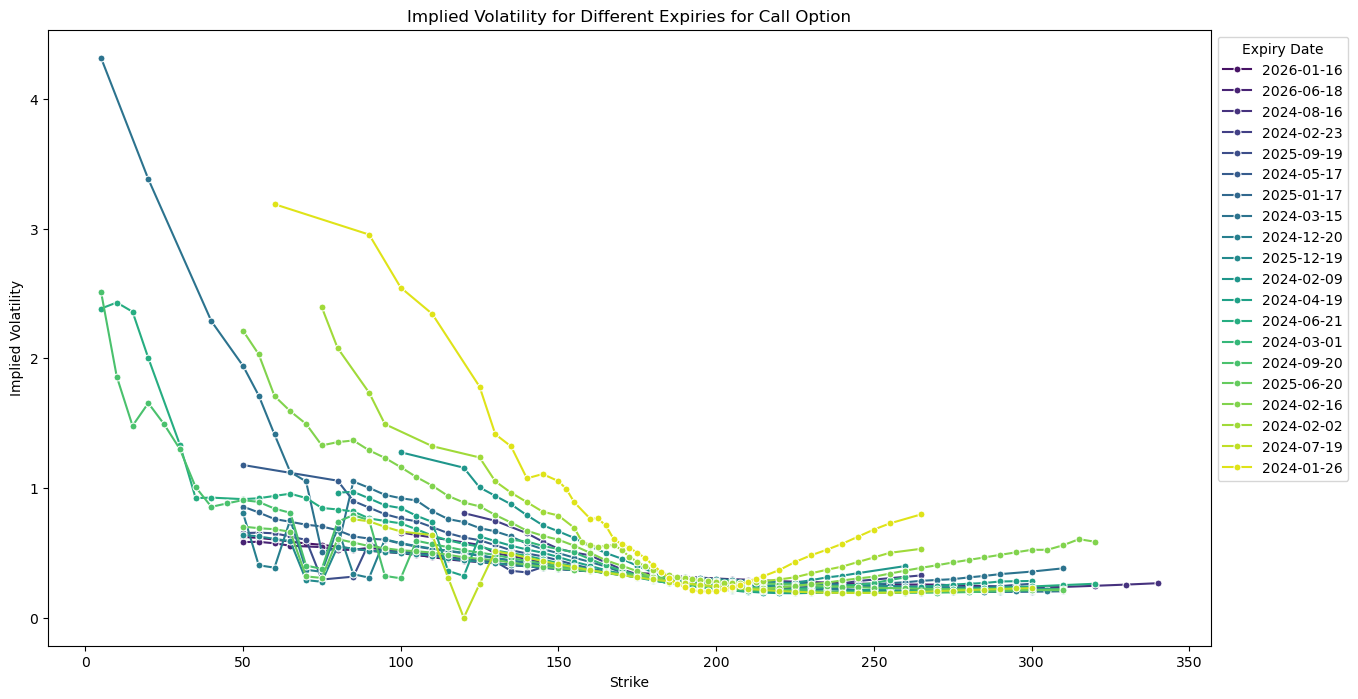

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a color palette for better distinguishability
palette = sns.color_palette('viridis', n_colors=len(set(option_implied_volatility_call['expirationDate'])))

plt.figure(figsize=(15, 8))

for i, expiry_date in enumerate(set(option_implied_volatility_call['expirationDate'])):
    df = option_implied_volatility_call[option_implied_volatility_call['expirationDate'] == expiry_date].copy()
    
    # Smooth out the curves using a rolling mean
    df['smoothed_IV'] = df['impliedVolatility'].rolling(window=2, min_periods=1).mean()
    
    # Plot the smoothed curve with markers and the specified color from the palette
    sns.lineplot(data=df, x='strike', y='smoothed_IV', label=expiry_date, color=palette[i], marker='o', markersize=5)

plt.title('Implied Volatility for Different Expiries for Call Option')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.legend(title='Expiry Date', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()



- In this plot we will see how the IV for different Call option  with the different expiries vary witht the strike price. We can see that the latest expiry has the hightest IV curve followed by upcoming expiries.
- Near ITM has lowest IV whereas OTM and DOTM has high IVs

#### Implied Volatilities for Different Expiries for Put Option Contracts

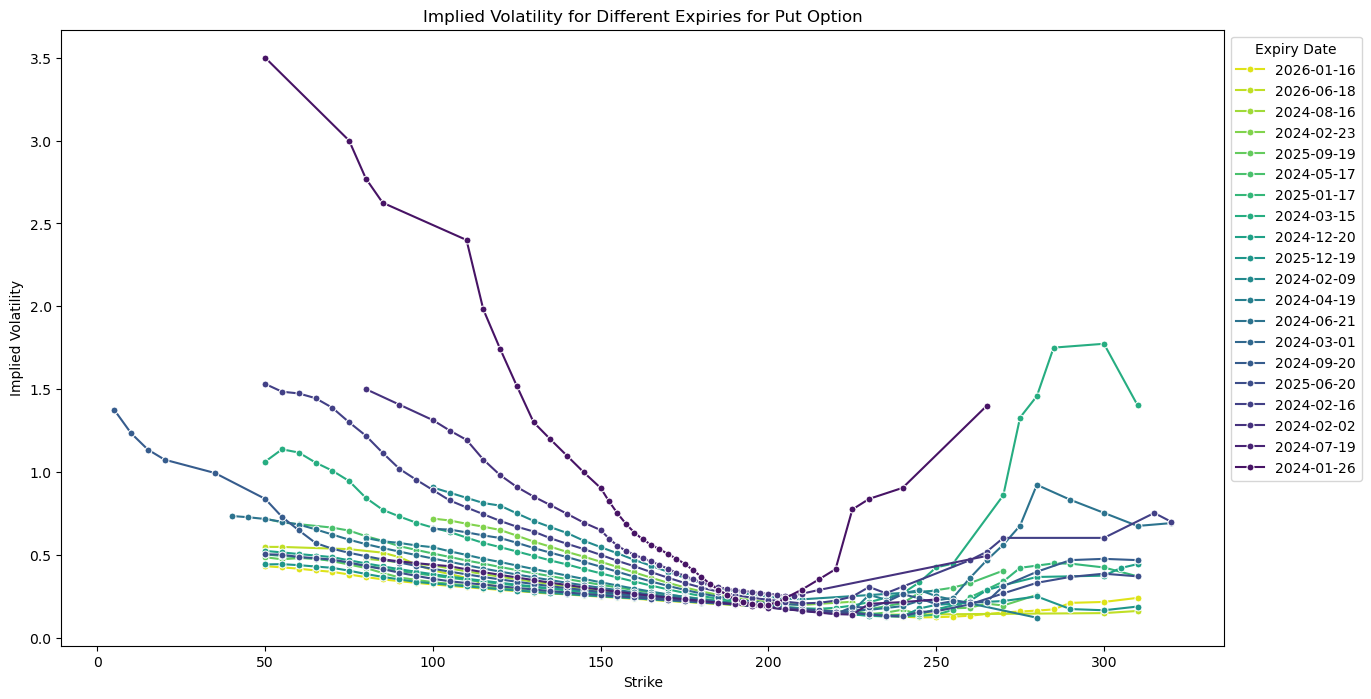

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a reversed color palette for better distinguishability
palette_put = sns.color_palette('viridis', n_colors=len(set(option_implied_volatility_put['expirationDate'])))
reversed_palette_put = list(reversed(palette_put))

plt.figure(figsize=(15, 8))

for i, expiry_date in enumerate(set(option_implied_volatility_put['expirationDate'])):
    df_put = option_implied_volatility_put[option_implied_volatility_put['expirationDate'] == expiry_date].copy()
    
    # Smooth out the curves using a rolling mean
    df_put['smoothed_IV'] = df_put['impliedVolatility'].rolling(window=5, min_periods=1).mean()
    
    # Plot the smoothed curve with markers and the specified color from the reversed palette
    sns.lineplot(data=df_put, x='strike', y='smoothed_IV', label=expiry_date, color=reversed_palette_put[i], marker='o', markersize=5)

plt.title('Implied Volatility for Different Expiries for Put Option')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.legend(title='Expiry Date', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


- In this plot we will see how the IV for different Put option  with the different expiries vary witht the strike price. We can see that the latest expiry has the hightest IV curve followed by upcoming expiries.
- Near ITM has lowest IV whereas OTM and DOTM has high IVs.
- We can see that on the right side, the curve has higher IV than call counterpart and forms the Smile Structure. These curves are not symmteric as assumed in the Black Scholes model. 

#### Plotting Total Volume for Call Put Option Contracts for Different Expiries

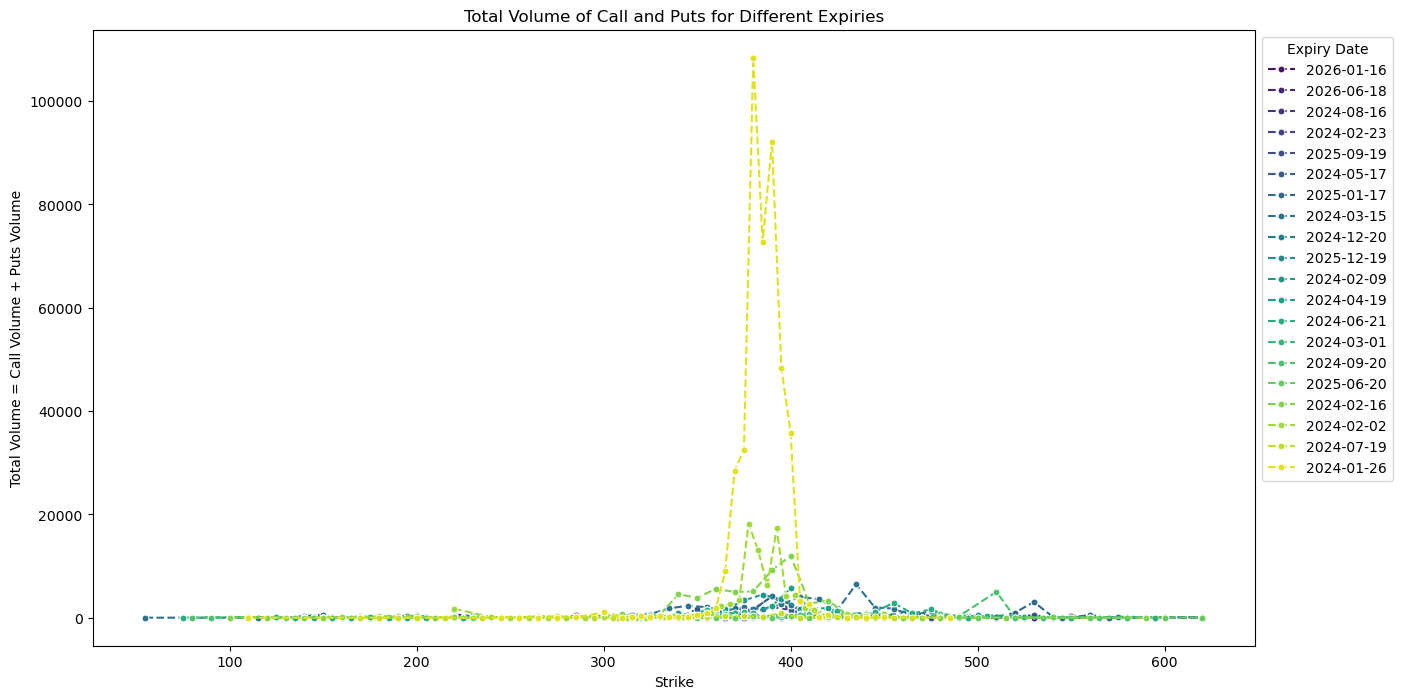

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a reversed color palette for better distinguishability
palette_volume = sns.color_palette('viridis', n_colors=len(set(option_call_put_volume['expirationDate'])))

plt.figure(figsize=(15, 8))

for i, expiry_date in enumerate(set(option_call_put_volume['expirationDate'])):
    df_volume = option_call_put_volume[option_call_put_volume['expirationDate'] == expiry_date].copy()
    
    # Plot histogram with markers and different line styles
    sns.lineplot(data=df_volume, x='strike', y='volume', label=expiry_date, 
                 color=palette_volume[i], marker='o', linestyle='--', markersize=5)

plt.title('Total Volume of Call and Puts for Different Expiries')
plt.xlabel('Strike')
plt.ylabel('Total Volume = Call Volume + Puts Volume')
plt.legend(title='Expiry Date', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


#### Plotting Open Interest Call Put Option for Different Expiries

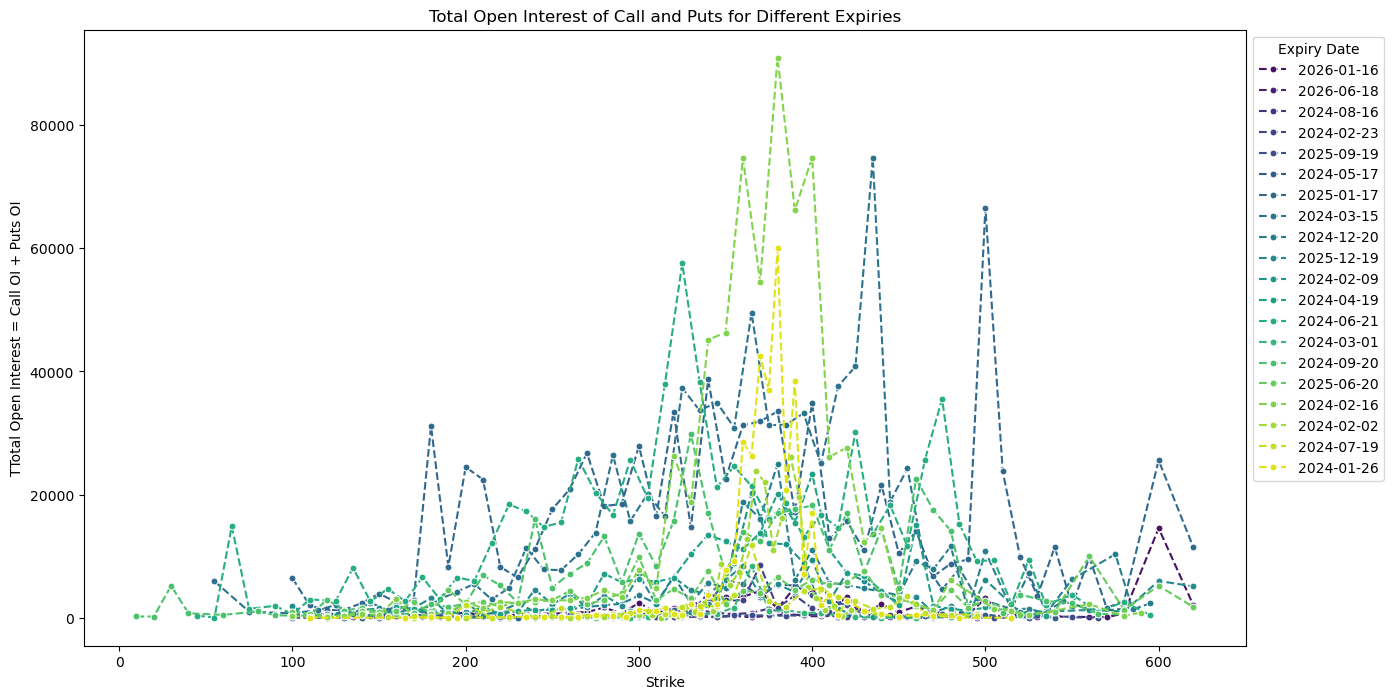

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a reversed color palette for better distinguishability
palette_volume = sns.color_palette('viridis', n_colors=len(set(option_call_put_volume['expirationDate'])))

plt.figure(figsize=(15, 8))

for i, expiry_date in enumerate(set(option_call_put_OI['expirationDate'])):
    df_OI = option_call_put_OI[option_call_put_OI['expirationDate'] == expiry_date].copy()
    
    # Plot histogram with markers and different line styles
    sns.lineplot(data=df_OI, x='strike', y='openInterest', label=expiry_date, 
                 color=palette_volume[i], marker='o', linestyle='--', markersize=5)

plt.title('Total Open Interest of Call and Puts for Different Expiries')
plt.xlabel('Strike')
plt.ylabel('TTotal Open Interest = Call OI + Puts OI')
plt.legend(title='Expiry Date', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

#### Filtering Option Chain Data in DataFrame

In this step we perform following steps 
- Change the format of date form object to datetime and use it to get the Expiration date
- Calcaulte the Maturity time left for each contracts
- Filter contracts based on whether they are call type or put type
- Converting object datatype to numeric
- Removing unwanted columns from dataframe

In [23]:
# change the format of date form object to datetime and use it to get the Expiration date
option['expirationDate'] = pd.to_datetime(option['expirationDate']) + datetime.timedelta(days = 1)     
# Calcaulte the Maturity time left for each contracts                
option['Time_to_Expire'] = (option['expirationDate'] - datetime.datetime.today()).dt.days / 365
# Filter contracts based on whether they are call type or put type
option['CALL'] = option['contractSymbol'].str[4:].apply(lambda x: "C" in x)
#Converting object datatype to numeric
option[['bid', 'ask', 'strike']] = option[['bid', 'ask', 'strike']].apply(pd.to_numeric)
#Removing unwanted columns from dataframe
option = option.drop(columns = ['contractSize', 'currency', 'change', 'percentChange', 'lastTradeDate', 'lastPrice'])
option

,contractSymbol,strike,bid,ask,volume,openInterest,impliedVolatility,inTheMoney,expirationDate,Time_to_Expire,CALL
0,AAPL240126C00060000,60.0,133.60,133.75,12.0,0,0.000010,True,2024-01-27,0.010959,True
1,AAPL240126C00090000,90.0,103.55,103.85,NaN,0,2.617191,True,2024-01-27,0.010959,True
2,AAPL240126C00100000,100.0,93.35,93.90,7.0,7,2.421879,True,2024-01-27,0.010959,True
3,AAPL240126C00110000,110.0,83.35,84.00,NaN,1,2.271489,True,2024-01-27,0.010959,True
4,AAPL240126C00125000,125.0,68.40,68.95,2.0,3,1.746095,True,2024-01-27,0.010959,True
...,...,...,...,...,...,...,...,...,...,...,...
1715,AAPL260618P00225000,225.0,36.35,39.50,25.0,26,0.156518,True,2026-06-19,2.405479,False
1716,AAPL260618P00230000,230.0,39.30,42.90,5.0,5,0.151421,True,2026-06-19,2.405479,False
1717,AAPL260618P00235000,235.0,42.90,44.50,NaN,1,0.123056,True,2026-06-19,2.405479,False
1718,AAPL260618P00300000,300.0,104.70,108.95,1.0,0,0.202126,True,2026-06-19,2.405479,False


##### Building Dictionary of Option Contract and Downloading Historical Data of Option Contraction 

In this code we make list of all option contracts symbols and store them in a dictionary, we will be using them for downloading historical data using yfinance library

In [10]:

option_contracts_list={}            # Create dictionary to sote the contract name/symbol
option_contracts_list['Call Contracts Tickers']=option[option['CALL']==True][['contractSymbol','strike','expirationDate']]
option_contracts_list['Put Contracts Tickers']=option[option['CALL']==False][['contractSymbol','strike','expirationDate']]


In this code we will download all the histrorical data of option contracts using yfinance library. We will be using this data for empirically testing the Iron condor PnL and Iron condor with Extra Put PnL

In [11]:
# Creating Dictionary of options Contract hisotrical data
option_contracts_data={}
for contracts in option_contracts_list['Call Contracts Tickers']['contractSymbol'].to_list():
    option_contracts_data['Call Contracts '] = {contracts:yf.download(contracts)}
for contracts in option_contracts_list['Put Contracts Tickers']['contractSymbol'].to_list():
    option_contracts_data['Put Contracts'] = {contracts:yf.download(contracts)}


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

#### Find the ITM Strike Price in the Option chain of Provided Expiry 

In [12]:
recent_expiry=expirations_dates_list[2]    # Taking it as the Latest Date of Expiry
recent_expiry

'2024-02-09'

In [24]:
# Checking the spot price 
print("The spot Price of AAPL is ",np.round(spot_price,2))   # AAPL to be changed to general ticker symbol
# Checking the ITM Strike Price 
ITM_stike=0
for x in option_chain_data[recent_expiry]['strike'].to_list():
    if x<spot_price:
        pass
    else:
        ITM_stike = x
        break
print("In The Money  Strike is ",ITM_stike)

The spot Price of AAPL is  193.74
In The Money  Strike is  195.0


In [26]:
option_chain_data[recent_expiry]   # Filter the option data for the recent strike price 

,contract Call,Price Call,Price Change Call,Price %Change Call,Call Volume,Call OI,Call IV,strike,Price Put,Price Change Put,Price %Change Put,Put Volume,Put OI,Put IV,contract Put
0,AAPL240209C00100000,82.45,0.000000,0.000000,2.0,3,1.296879,100.0,0.01,0.000000,0.000000,20.0,82,0.906251,AAPL240209P00100000
1,AAPL240209C00120000,62.73,0.000000,0.000000,1.0,1,1.003911,120.0,0.02,0.000000,0.000000,1.0,17,0.734378,AAPL240209P00120000
2,AAPL240209C00125000,60.50,0.000000,0.000000,NaN,2,0.956055,125.0,0.02,0.000000,0.000000,267.0,203,0.671878,AAPL240209P00125000
3,AAPL240209C00130000,61.48,0.000000,0.000000,1.0,1,0.823244,130.0,0.01,-0.010000,-50.000000,30.0,27,0.617191,AAPL240209P00130000
4,AAPL240209C00135000,59.79,11.910000,24.874685,30.0,1,0.849611,135.0,0.02,0.000000,0.000000,6.0,45,0.593754,AAPL240209P00135000
5,AAPL240209C00140000,50.41,0.000000,0.000000,1.0,3,0.766604,140.0,0.03,0.000000,0.000000,10.0,85,0.539067,AAPL240209P00140000
6,AAPL240209C00145000,42.03,0.000000,0.000000,NaN,1,0.704105,145.0,0.04,0.000000,0.000000,1.0,96,0.501958,AAPL240209P00145000
7,AAPL240209C00150000,44.14,4.570000,11.549152,10.0,10,0.641605,150.0,0.05,-0.010000,-16.666664,23.0,340,0.478521,AAPL240209P00150000
8,AAPL240209C00155000,37.20,0.000000,0.000000,1.0,931,0.542973,155.0,0.07,-0.020000,-22.222225,21.0,453,0.432623,AAPL240209P00155000
9,AAPL240209C00160000,35.80,3.799999,11.874998,14.0,175,0.510747,160.0,0.09,-0.040000,-30.769226,17.0,441,0.397467,AAPL240209P00160000


## STEP 2 : Visualizating Iron Condor and its Variations 


In this step we see different variation of Iron Condor and how they behave with different Stirkes, Different spread and differnt premiums 

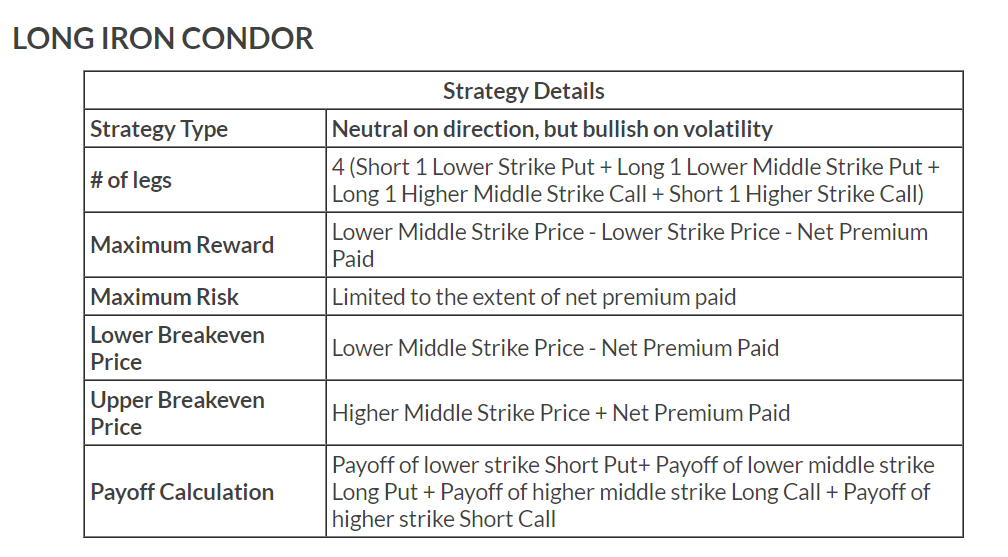

### Building Long Iron Condor (4 leged Strategy):


1. Buy 1 OTM Put (Lower Strike than spot ) 
2. Buy 1 OTM Call (Higer Strike than spot ) 
3. Sell 1 OTM Put (More Lower Strike than spot) 
4. Sell 1 OTM Call (More Higher Strike than spot)

Maximum Profit:  Net Premium Received

Maximum Loss: 
Strike Price of Long Call - Strike Price of Short Call - Net Premium Received or (Strike Price of Short Put - Strike Price of Long Put - Net Premium Received) whichever is higher

Breakeven:
Upper side: Strike Price of Short Call + Net Premium Received Lower side: Strike Price of Short Put - Net Premium Received


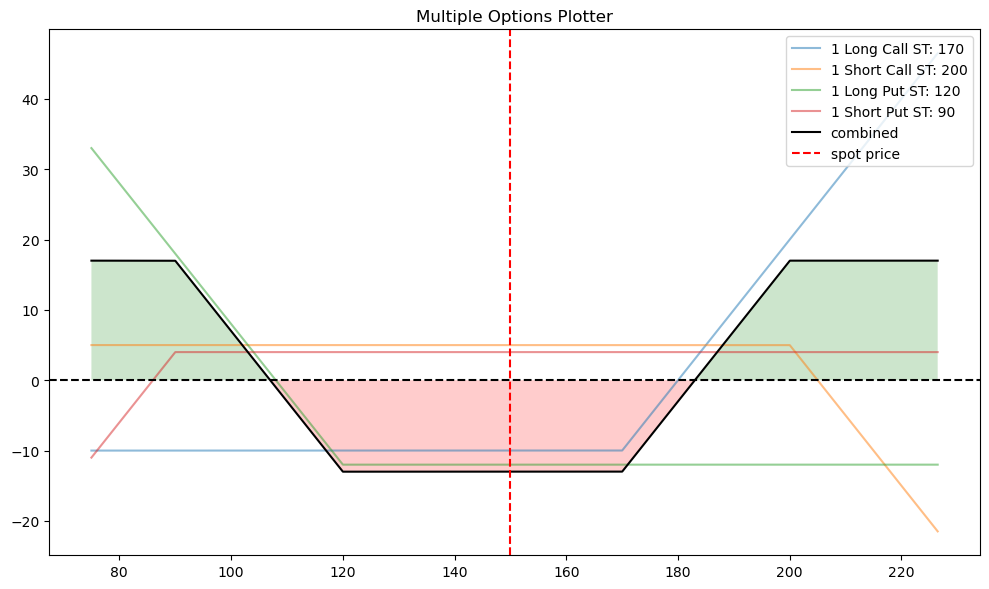

In [34]:
op1={'op_type': 'c', 'strike': 170, 'tr_type': 'b', 'op_pr': 10}
op2={'op_type': 'c', 'strike': 200, 'tr_type': 's', 'op_pr': 5}
op3={'op_type': 'p', 'strike': 120, 'tr_type': 'b', 'op_pr': 12}
op4={'op_type': 'p', 'strike': 90, 'tr_type': 's', 'op_pr': 4}

op_list=[op1, op2, op3, op4]
op.multi_plotter(spot=150,spot_range=50, op_list=op_list)


### Building Short Iron Condor (4 leged Strategy):




    1. Sell 1 OTM Put (Lower Strike than spot ) 
    2. Sell 1 OTM Call (Higer Strike than spot ) 
    3. Buy 1 OTM Put (More Lower Strike than spot) 
    4. Buy 1 OTM Call (More Higher Strike than spot)

Maximum Profit:  Net Premium Received

Maximum Loss: 
Strike Price of Long Call - Strike Price of Short Call - Net Premium Received or (Strike Price of Short Put - Strike Price of Long Put - Net Premium Received) whichever is higher

Breakeven:
Upper side: Strike Price of Short Call + Net Premium Received Lower side: Strike Price of Short Put - Net Premium Received


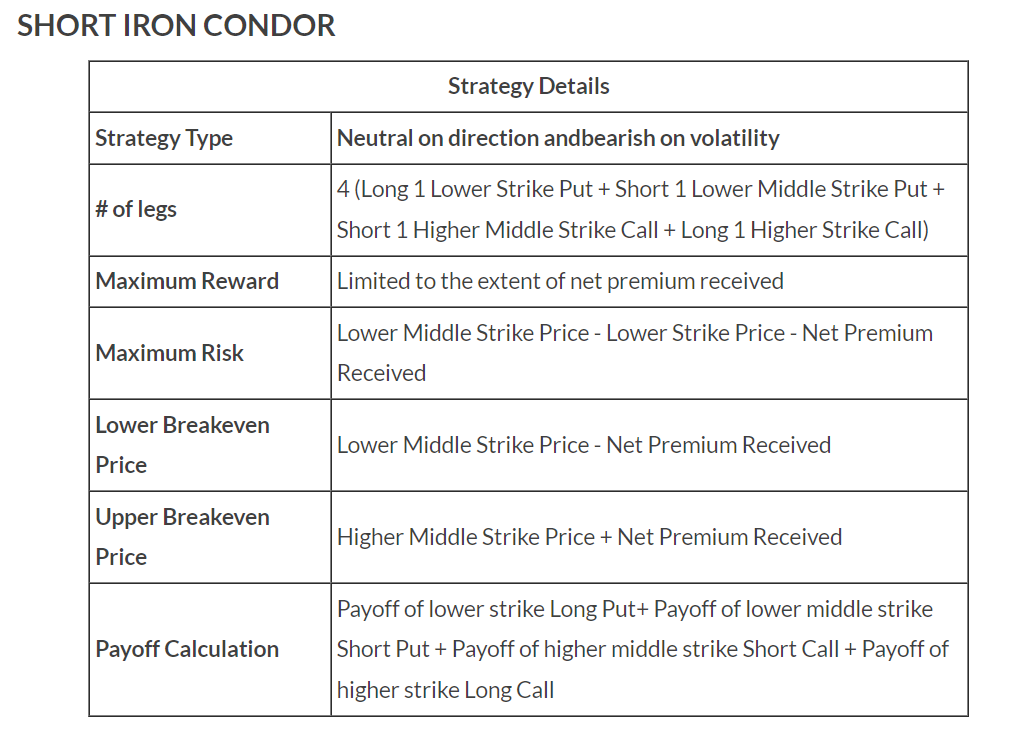

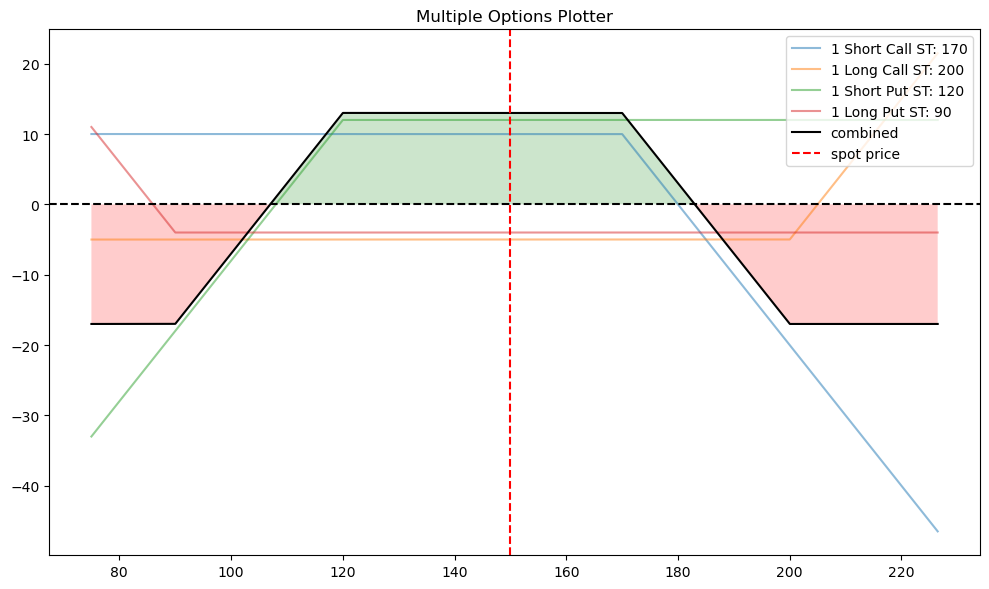

In [15]:
op1={'op_type': 'c', 'strike': 170, 'tr_type': 's', 'op_pr': 10}
op2={'op_type': 'c', 'strike': 200, 'tr_type': 'b', 'op_pr': 5}
op3={'op_type': 'p', 'strike': 120, 'tr_type': 's', 'op_pr': 12}
op4={'op_type': 'p', 'strike': 90, 'tr_type': 'b', 'op_pr': 4}

op_list=[op1, op2, op3, op4]
op.multi_plotter(spot=150,spot_range=50, op_list=op_list)


### Building Asymmetric Iron Condor With Extra Long Put

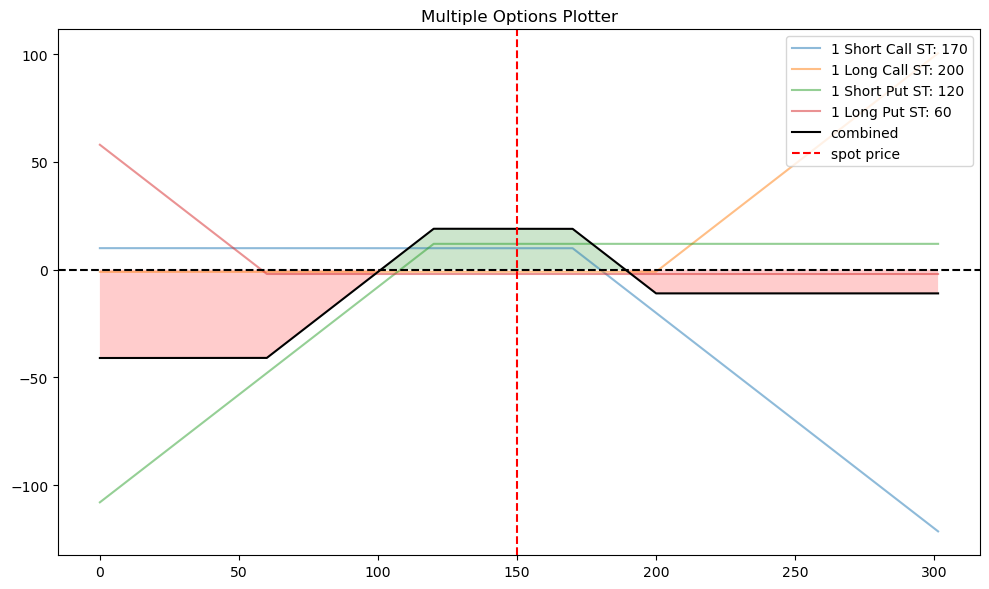

In [50]:
op1={'op_type': 'c', 'strike': 170, 'tr_type': 's', 'op_pr': 10}
op2={'op_type': 'c', 'strike': 200, 'tr_type': 'b', 'op_pr': 1}
op3={'op_type': 'p', 'strike': 120, 'tr_type': 's', 'op_pr': 12}
op4={'op_type': 'p', 'strike': 60,  'tr_type': 'b', 'op_pr': 2}

op_list=[op1, op2, op3, op4]
op.multi_plotter(spot=150,spot_range=100, op_list=op_list)


### Building 5 Legged Short Iron Condor  

#### With extra OTM long put

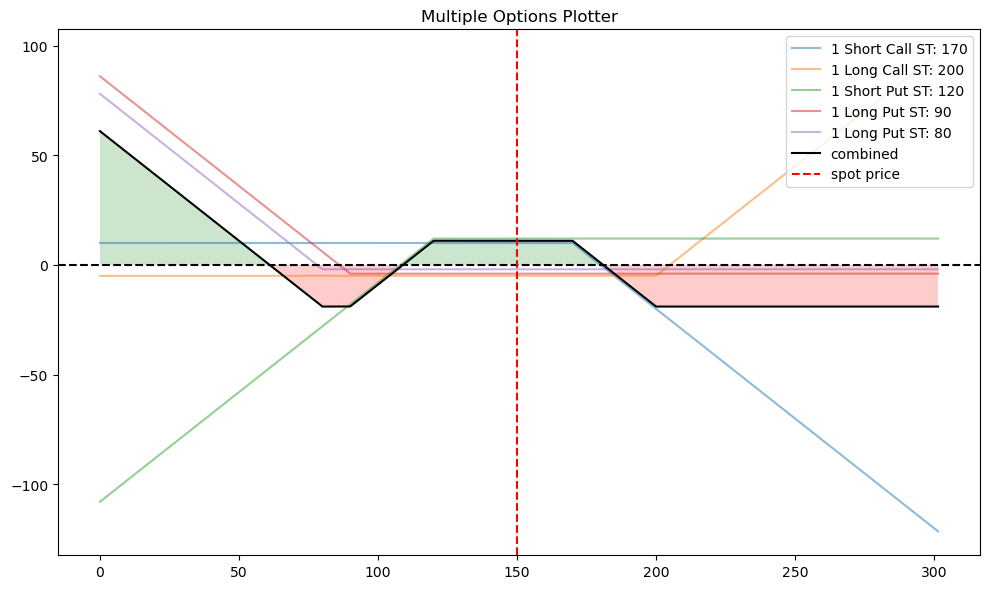

In [16]:
op1={'op_type': 'c', 'strike': 170, 'tr_type': 's', 'op_pr': 10}
op2={'op_type': 'c', 'strike': 200, 'tr_type': 'b', 'op_pr': 5}
op3={'op_type': 'p', 'strike': 120, 'tr_type': 's', 'op_pr': 12}
op4={'op_type': 'p', 'strike': 90,  'tr_type': 'b', 'op_pr': 4}
op5={'op_type': 'p', 'strike': 80,  'tr_type': 'b', 'op_pr': 2}

op_list=[op1, op2, op3, op4, op5]
op.multi_plotter(spot=150,spot_range=100, op_list=op_list)

#### With extra ATM long put  

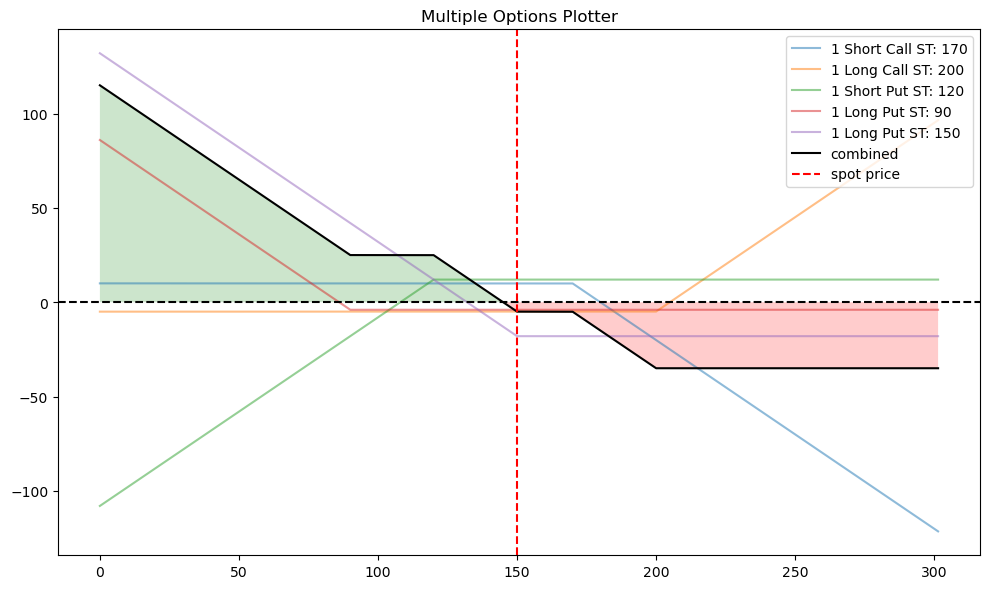

In [17]:
op1={'op_type': 'c', 'strike': 170, 'tr_type': 's', 'op_pr': 10}
op2={'op_type': 'c', 'strike': 200, 'tr_type': 'b', 'op_pr': 5}
op3={'op_type': 'p', 'strike': 120, 'tr_type': 's', 'op_pr': 12}
op4={'op_type': 'p', 'strike': 90,  'tr_type': 'b', 'op_pr': 4}
op5={'op_type': 'p', 'strike': 150,  'tr_type': 'b', 'op_pr': 18}

op_list=[op1, op2, op3, op4, op5]
op.multi_plotter(spot=150,spot_range=100, op_list=op_list)

#### With extra ITM long put  

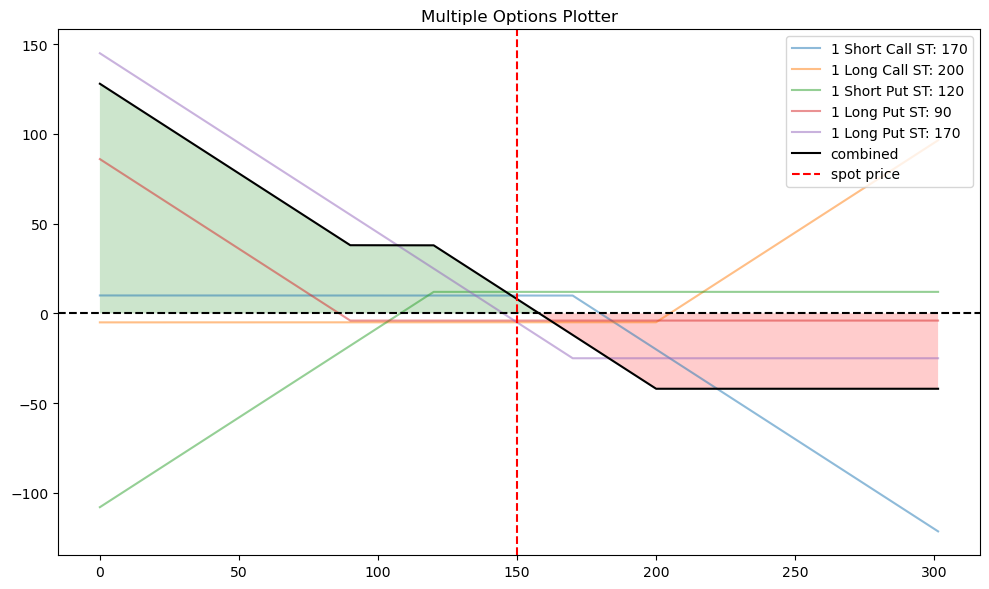

In [18]:
op1={'op_type': 'c', 'strike': 170, 'tr_type': 's', 'op_pr': 10}
op2={'op_type': 'c', 'strike': 200, 'tr_type': 'b', 'op_pr': 5}
op3={'op_type': 'p', 'strike': 120, 'tr_type': 's', 'op_pr': 12}
op4={'op_type': 'p', 'strike': 90,  'tr_type': 'b', 'op_pr': 4}
op5={'op_type': 'p', 'strike': 170,  'tr_type': 'b', 'op_pr': 25}

op_list=[op1, op2, op3, op4, op5]
op.multi_plotter(spot=150,spot_range=100, op_list=op_list)

### Assumption 
Since the actual delta values are not available we will use the %percentage change of Option Price as substitute. This is because spot price changes equally for calls and puts, so percetage change will be proportional to delta.  

In [36]:
ITM_stike

195.0

From above option chain we will choose call and put options with similar delta. We will start finding such options taking ITM option as the base and move up the stikes in case of call and down in strikes in case of puts, as we have find neary OTM' for selling. Then we will look for deeper OTM options for buying

In [40]:
# Finding the index of ITM in the Option Chain Data
ITM_index=option_chain_data[recent_expiry].index[option_chain_data[recent_expiry]['strike']==ITM_stike].to_list()[0]
delta_diff=option_chain_data[recent_expiry]['Price Change Call']- option_chain_data[recent_expiry]['Price Change Put']

same_delta_option_pairs =[]
for x in range(10):   # Going 10 strike up and down from ITM Strike
    call_delta=option_chain_data[recent_expiry].iloc[ITM_index-x]["Price Change Call"]
    for x in range(10):
        put_delta=option_chain_data[recent_expiry].iloc[ITM_index+x]["Price Change Put"]
        if abs(put_delta-call_delta)<5:
            pair=(ITM_index-x,ITM_index+x)
            (same_delta_option_pairs.append(pair)) 
same_delta_option_pairs=list(set(same_delta_option_pairs))
same_delta_option_pairs.sort()
same_delta_option_pairs



In [41]:
same_delta_option_pairs
delta_pairs=pd.DataFrame()
for pair in same_delta_option_pairs:
    call=option_chain_data[recent_expiry].iloc[pair[0]][['Price Call','strike']]
    put=option_chain_data[recent_expiry].iloc[pair[1]][['Price Put','strike']]
    pair=pd.concat([call,put])
    delta_pairs=pd.concat([delta_pairs,pair],axis=1,ignore_index=True)
delta_pairs=delta_pairs.T
delta_pairs

,Price Call,strike,Price Put,strike
0,3.89,195.0,4.87,195.0
1,6.72,190.0,7.85,200.0
2,10.5,185.0,11.65,205.0
3,14.66,180.0,20.25,210.0


Choosing 7th and 6th int his order only 

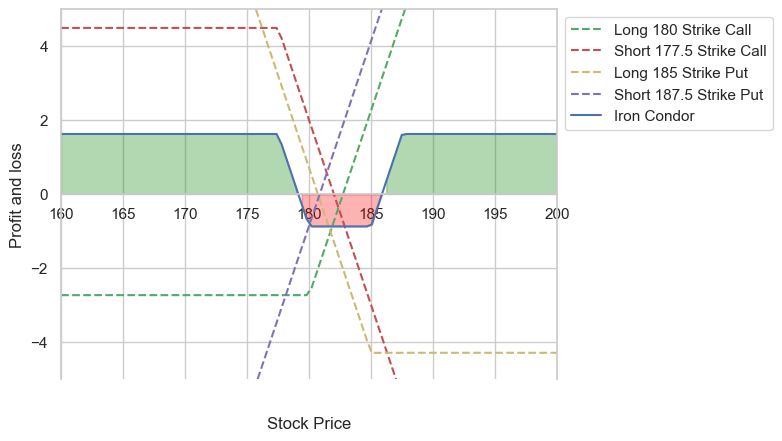

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the spot price and create an array of stock prices
spot_price = 185.0
sT = np.linspace(160, 200, 100)

def call_payoff(sT, strike_price, premium):
    return np.where(sT > strike_price, sT - strike_price, 0) - premium

def put_payoff(sT, strike_price, premium):
    return np.where(sT < strike_price, strike_price - sT, 0) - premium

# Long call
strike_price_long_call = 180.0
premium_long_call = 2.73
payoff_long_call = call_payoff(sT, strike_price_long_call, premium_long_call)

# Short call
strike_price_short_call = 177.5
premium_short_call = 4.5
payoff_short_call = call_payoff(sT, strike_price_short_call, premium_short_call) * -1.0

# Long put
strike_price_long_put = 185.0
premium_long_put = 4.29
payoff_long_put = put_payoff(sT, strike_price_long_put, premium_long_put)

# Short put
strike_price_short_put = 187.5
premium_short_put = 6.65
payoff_short_put = put_payoff(sT, strike_price_short_put, premium_short_put) * -1.0

# Iron Condor Plot
payoff = payoff_long_call + payoff_short_call + payoff_long_put + payoff_short_put

# Use Seaborn without whitegrid style
sns.set(style="whitegrid", rc={"axes.grid": False})
fig, ax = plt.subplots()
ax.spines['bottom'].set_position('zero')
ax.plot(sT, payoff_long_call, '--', label='Long 180 Strike Call', color='g')
ax.plot(sT, payoff_short_call, '--', label='Short 177.5 Strike Call', color='r')
ax.plot(sT, payoff_long_put, '--', label='Long 185 Strike Put', color='y')
ax.plot(sT, payoff_short_put, '--', label='Short 187.5 Strike Put', color='m')
ax.plot(sT, payoff, label='Iron Condor')

# Fill regions above and below zero with different colors
ax.fill_between(sT, payoff, where=(payoff >= 0), color='green', alpha=0.3)
ax.fill_between(sT, payoff, where=(payoff < 0), color='red', alpha=0.3)

plt.xlabel('Stock Price')
plt.ylabel('Profit and loss')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside
plt.grid()
plt.xlim(160, 200)
plt.ylim(-5, 5)  # Set y-axis range from -5 to 5
ax.xaxis.set_label_coords(0.5, -0.1)  # Adjust the x-axis label position
plt.show()


Spot Price: 185
Lower Breakeven: 188.0
Upper Breakeven: 182.0
Maximum Loss: -5.0
Maximum Profit: -6.0
Net Premium: 0.0
Payoff Diagram: {'Stock Prices': array([ 85.        ,  85.2002002 ,  85.4004004 ,  85.6006006 ,
        85.8008008 ,  86.001001  ,  86.2012012 ,  86.4014014 ,
        86.6016016 ,  86.8018018 ,  87.002002  ,  87.2022022 ,
        87.4024024 ,  87.6026026 ,  87.8028028 ,  88.003003  ,
        88.2032032 ,  88.4034034 ,  88.6036036 ,  88.8038038 ,
        89.004004  ,  89.2042042 ,  89.4044044 ,  89.6046046 ,
        89.8048048 ,  90.00500501,  90.20520521,  90.40540541,
        90.60560561,  90.80580581,  91.00600601,  91.20620621,
        91.40640641,  91.60660661,  91.80680681,  92.00700701,
        92.20720721,  92.40740741,  92.60760761,  92.80780781,
        93.00800801,  93.20820821,  93.40840841,  93.60860861,
        93.80880881,  94.00900901,  94.20920921,  94.40940941,
        94.60960961,  94.80980981,  95.01001001,  95.21021021,
        95.41041041,  95.6106

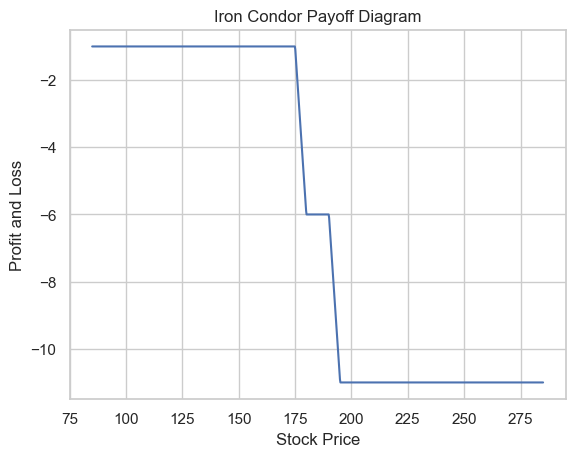

In [ ]:
import numpy as np

def iron_condor_analysis(spot_price, long_put_strike, short_put_strike, short_call_strike, long_call_strike,
                         long_put_premium, short_put_premium, short_call_premium, long_call_premium,
                         lot_size=1):
    # Spot price and stock prices array
    spot = spot_price
    sT = np.linspace(spot - 100, spot + 100, 1000)

    # Payoff functions for each leg
    def put_payoff(sT, strike, premium):
        return np.where(sT < strike, strike - sT, 0) - premium

    def call_payoff(sT, strike, premium):
        return np.where(sT > strike, sT - strike, 0) - premium

    # Long Put Payoff
    payoff_long_put = put_payoff(sT, long_put_strike, long_put_premium)

    # Short Put Payoff
    payoff_short_put = put_payoff(sT, short_put_strike, short_put_premium) * -1.0

    # Short Call Payoff
    payoff_short_call = call_payoff(sT, short_call_strike, short_call_premium) * -1.0

    # Long Call Payoff
    payoff_long_call = call_payoff(sT, long_call_strike, long_call_premium)

    # Iron Condor Payoff
    payoff_iron_condor = payoff_long_put + payoff_short_put + payoff_short_call + payoff_long_call

    # Calculate the Breakeven points
    lower_breakeven = spot - short_put_premium + long_put_premium
    upper_breakeven = spot + short_call_premium - long_call_premium

    # Calculate the Maximum Loss and Maximum Profit
    max_loss = max(short_put_strike - long_put_strike, short_call_strike - long_call_strike) \
               - (short_put_premium - long_put_premium) + (short_call_premium - long_call_premium)

    max_profit = (short_put_premium - long_put_premium + short_call_premium - long_call_premium) * lot_size

    # Calculate the net premium paid or received
    net_premium = (long_put_premium + short_call_premium - short_put_premium - long_call_premium) * lot_size

    return {
        'Spot Price': spot,
        'Lower Breakeven': lower_breakeven,
        'Upper Breakeven': upper_breakeven,
        'Maximum Loss': max_loss,
        'Maximum Profit': max_profit,
        'Net Premium': net_premium,
        'Payoff Diagram': {'Stock Prices': sT, 'Payoff': payoff_iron_condor}
    }

# Example usage:
analysis_result = iron_condor_analysis(spot_price=185,
                                       long_put_strike=180,
                                       short_put_strike=175,
                                       short_call_strike=190,
                                       long_call_strike=195,
                                       long_put_premium=5.0,
                                       short_put_premium=2.0,
                                       short_call_premium=3.0,
                                       long_call_premium=6.0,
                                       lot_size=1)

# Print the analysis results
for key, value in analysis_result.items():
    print(f'{key}: {value}')

# Plot the Payoff Diagram
import matplotlib.pyplot as plt

plt.plot(analysis_result['Payoff Diagram']['Stock Prices'], analysis_result['Payoff Diagram']['Payoff'])
plt.title('Iron Condor Payoff Diagram')
plt.xlabel('Stock Price')
plt.ylabel('Profit and Loss')
plt.grid(True)
plt.show()


In [ ]:
#variables

spot_price = 100

short_OTM_put=2.5    
short_OTM_call=2.5

long_OTM_put=1
long_OTM_call=1


In [ ]:
# option chain  data for latest expiry 

data=option_chain_data['2024-01-12'][["lastPrice_x","strike","lastPrice_y"]]


KeyError: "['lastPrice_x', 'lastPrice_y'] not in index"

In [ ]:
spot_price

181.17999267578125

In [ ]:
ATM=list(filter(lambda x: data['strike'].to_list[x] > spot_price, range(len(data['strike'].to_list))))
ATM

TypeError: list indices must be integers or slices, not float

In [ ]:
# strike closest to the spot 
ATM_strike=min(data['strike'].to_list)


TypeError: 'method' object is not iterable

In [ ]:
# Maximum Profit:
# In case stock doesn’t bounce much and stays between my booked positions i.e. between the price of INR 160 and INR 230. Payoff will be as follows:
premium_sum = short_OTM_put+ short_OTM_call - long_OTM_put-long_OTM_call

#Maximum Loss:
# If there is a major volatility or the market bumps due to an uncertain event and made the stock to go up 
premium_sum = short_OTM_put+ short_OTM_call - long_OTM_put-long_OTM_call


## Step 3 : Empirically Testing Iron Condor Strategy  v/s  Iron Condor with Extra Puts

Maximum Profit: 35
Maximum Loss: -35
Breakeven Upper: 80
Breakeven Lower: 101


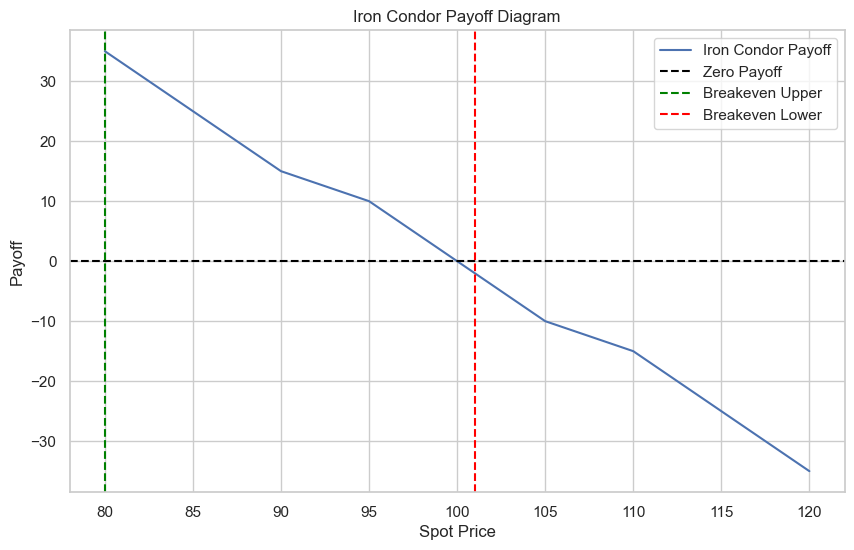

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def iron_condor_metrics(spot_prices, short_condor, put_lower_strike, put_upper_strike, call_lower_strike, call_upper_strike, put_premium, call_premium):
    """
    Calculate maximum profit, maximum risk or loss, breakeven strike prices,
    and plot the payoff diagram for an Iron Condor.

    Parameters:
    - spot_prices (array): Array of spot prices.
    - short_condor (bool): True for short Iron Condor, False for long Iron Condor.
    - put_lower_strike (float): Lower strike price of the put spread.
    - put_upper_strike (float): Upper strike price of the put spread.
    - call_lower_strike (float): Lower strike price of the call spread.
    - call_upper_strike (float): Upper strike price of the call spread.
    - put_premium (float): Premium received (for short) or paid (for long) for the put spread.
    - call_premium (float): Premium received (for short) or paid (for long) for the call spread.
    """

    # Calculate payoff for the Iron Condor
    put_payoff_lower = np.maximum(put_lower_strike - spot_prices, 0) - put_premium
    put_payoff_upper = np.maximum(spot_prices - put_upper_strike, 0) - put_premium
    call_payoff_lower = np.maximum(call_lower_strike - spot_prices, 0) - call_premium
    call_payoff_upper = np.maximum(spot_prices - call_upper_strike, 0) - call_premium

    if short_condor:
        iron_condor_payoff = - put_payoff_lower + put_payoff_upper - call_payoff_lower + call_payoff_upper
    else:
        iron_condor_payoff = put_payoff_lower - put_payoff_upper + call_payoff_lower - call_payoff_upper

    # Calculate metrics
    max_profit = max(iron_condor_payoff)
    max_loss = min(iron_condor_payoff)
    breakeven_upper = spot_prices[np.argmax(iron_condor_payoff >= 0)]
    breakeven_lower = spot_prices[np.argmin(iron_condor_payoff >= 0)]

    # Print metrics
    print(f"Maximum Profit: {max_profit}")
    print(f"Maximum Loss: {max_loss}")
    print(f"Breakeven Upper: {breakeven_upper}")
    print(f"Breakeven Lower: {breakeven_lower}")

    # Plot payoff diagram
    plt.figure(figsize=(10, 6))
    plt.plot(spot_prices, iron_condor_payoff, label='Iron Condor Payoff')
    plt.axhline(0, color='black', linestyle='--', label='Zero Payoff')
    plt.axvline(breakeven_upper, color='green', linestyle='--', label='Breakeven Upper')
    plt.axvline(breakeven_lower, color='red', linestyle='--', label='Breakeven Lower')
    plt.title('Iron Condor Payoff Diagram')
    plt.xlabel('Spot Price')
    plt.ylabel('Payoff')
    plt.legend()
    plt.grid(True)
    plt.show()


spot_prices = np.arange(80, 121, 1)
short_condor = False 
put_lower_strike = 90
put_upper_strike = 95
call_lower_strike = 105
call_upper_strike = 110
put_premium = 2
call_premium = 2

iron_condor_metrics(spot_prices, short_condor, put_lower_strike, put_upper_strike, call_lower_strike, call_upper_strike, put_premium, call_premium)


## Step 4 : Building Strategy to deploy an Iron Condor and its Variation